In [1]:
import pandas as pd
import numpy as np
import os
import sys
import warnings
sys.path.append('./src/')
from pypfopt import EfficientFrontier
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import algorithm as al

RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xe

(CVXPY) Oct 04 09:30:10 PM: Encountered unexpected exception importing solver ECOS:
ImportError('numpy.core.multiarray failed to import')
(CVXPY) Oct 04 09:30:10 PM: Encountered unexpected exception importing solver GLPK:
ImportError("cannot import name 'glpk' from 'cvxopt' (/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/cvxopt/__init__.py)")
(CVXPY) Oct 04 09:30:10 PM: Encountered unexpected exception importing solver GLPK_MI:
ImportError("cannot import name 'glpk' from 'cvxopt' (/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/cvxopt/__init__.py)")


RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xe

(CVXPY) Oct 04 09:30:10 PM: Encountered unexpected exception importing solver ECOS_BB:
ImportError('numpy.core.multiarray failed to import')


In [2]:
# read regime
regime = pd.read_pickle('./data/regime/regime.pkl')

# read pool
pool = pd.read_pickle('./data/regime/pool_df.pkl')

# read stock data
stocks = pd.read_pickle('./data/regime/all_stocks.pkl')
stock_list = list(stocks.columns.to_list())

# read spy data
spy = pd.read_pickle('./data/stocks/spy.pkl')

In [3]:
regime[regime.index>'2018-10']

,state
Date,
2018-10-02,bull1
2018-10-03,bull1
2018-10-04,bear
2018-10-05,cris
2018-10-08,bear
...,...
2022-08-23,bear
2022-08-24,bull2
2022-08-25,bull2


In [4]:
regime.iloc[-1,:][0]

'bull2'

In [5]:
pool.head()

,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,0,1,1,1,1,1,1,1,0,1,...,0,0,1,0,1,1,1,1,0,1
2018-01-03,1,1,1,1,1,1,1,1,1,1,...,0,1,1,0,1,1,1,1,0,1
2018-01-04,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,1,1,1,1,0,1
2018-01-05,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,1,1,1,1,1,1
2018-01-08,1,1,1,1,1,1,1,1,1,1,...,0,1,1,0,1,1,1,1,1,1


In [6]:
stocks.head()

,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2007-08-01 00:00:00,24.830606,28.697052,31.488310,4.116690,18.598913,10.28,17.197018,31.246460,39.580002,24.591806,...,74.684135,15.559514,57.119190,11.895068,49.974968,33.670444,16.927359,70.522545,36.410000,59.761684
2007-08-02 00:00:00,25.129925,28.942163,32.129063,4.162127,18.502197,10.98,17.284765,31.735386,39.520000,24.815556,...,74.443825,15.277222,59.724373,11.923719,49.590725,33.507782,17.109375,69.866684,36.619999,59.745808
2007-08-03 00:00:00,24.713476,29.356966,30.820082,4.020632,18.574739,10.46,17.244265,30.840256,38.750000,24.042610,...,72.650673,14.803766,59.565212,11.345008,47.785950,33.607197,16.756052,68.333405,36.520000,57.183327
2007-08-06 00:00:00,24.928205,28.282246,31.149612,4.124312,19.211496,10.99,17.929445,31.374329,39.380001,24.849463,...,75.035393,15.081611,63.296146,11.786206,48.635948,34.348202,17.168262,69.263992,36.000000,60.974262
2007-08-07 00:00:00,24.921705,29.479525,30.957394,4.117606,18.433691,11.72,18.327732,31.562370,39.419998,24.903702,...,73.537979,15.194982,69.667603,12.026857,49.893486,34.230724,17.087955,69.919868,36.000000,61.453125


In [7]:
# a simple strategy
def strategy(states):
    
    tail15 = states.tail(10)
    tail5 = states.tail(5)
#     print(tail7)
    c_count = int(tail15[tail15=='cris'].count())
    b_count = int(tail5[tail5=='bear'].count())
#     bull_count = int(tail15[tail15=='bull1'].count()) + int(tail15[tail15=='bull2'].count())
    if states.iloc[-1,:][0]=='cris' or c_count>0:
        return -2
    elif states.iloc[-1,:][0]=='bear' or b_count >1:
        return -1
    else:
        return 1

In [8]:
def process_weights(w, stock_list):
    """
    This function add stocks which weight == 0 to dict
    """
    s = list(w.keys())
    missing = [x for x in stocks if x not in s]
    missing_w = {key: 0 for key in missing}
    return w|missing_w

In [9]:
def backtest():
    date = regime.index.to_list()
    init_w ={key: 0 for key in stock_list}
    position = pd.DataFrame(init_w, index=date)
    prev_strategy = 0
    # sometimes there's no solution due to a bad estimation of cov matrix
    failed_date = []
    
    for d in tqdm(date):
        # read current regime and decide which optimization method to use
        curr_state = regime[regime.index <= d]
        curr_strategy = strategy(curr_state)
    
    # if in t-1, fail to find an optimization solution
#     if d - failed_data = pd.Timedelta(days=1):
        
    # strategy decision
        if curr_strategy == 1 and prev_strategy <= 0:
            try:
                mu,S = al.estimate(stocks, pool, d, 360)
                ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
                raw_weights = ef.max_sharpe()
                w = ef.clean_weights()
            except:
                failed_date.append(d)
            prev_strategy += 1

        elif curr_strategy == 1 and prev_strategy ==1:
            w = w
            prev_strategy += 1

        elif curr_strategy == 1 and prev_strategy >= 90:
            try:
                mu,S = al.estimate(stocks, pool, d, 360)
                ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
                raw_weights = ef.max_sharpe()
                w = ef.clean_weights()
            except:
                failed_date.append(d)
            prev_strategy = 1

        elif curr_strategy == -1 and prev_strategy != -1 and prev_strategy != -2:
    #         print(-1)
            try:
                mu,S = al.estimate(stocks, pool, d, 360)
                ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
                raw_weights = ef.max_quadratic_utility()
                w = ef.clean_weights()
            except:
                failed_date.append(d)
            prev_strategy = -1

        elif curr_strategy == -2:
    #         print(-2)
            w = init_w
            prev_strategy = -2
        else:
            pass
        w = process_weights(w, stock_list)
        position.loc[d, :] = w
    return position,failed_date

In [10]:
# position.to_pickle('./data/regime/postion3.pkl')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    position,failed_date = backtest()

100%|███████████████████████████████████████████████| 1173/1173 [01:36<00:00, 12.11it/s]


In [12]:
failed_date

[Timestamp('2020-04-30 00:00:00'),
 Timestamp('2020-06-02 00:00:00'),
 Timestamp('2020-06-03 00:00:00'),
 Timestamp('2020-07-31 00:00:00'),
 Timestamp('2020-08-12 00:00:00'),
 Timestamp('2020-08-13 00:00:00'),
 Timestamp('2020-12-07 00:00:00'),
 Timestamp('2020-12-10 00:00:00'),
 Timestamp('2020-12-11 00:00:00'),
 Timestamp('2020-12-16 00:00:00')]

In [13]:
position

,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
2018-01-02,0,0.0,0.0,0.01201,0,0.0,0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
2018-01-03,0,0.0,0.0,0.01201,0,0.0,0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
2018-01-04,0,0.0,0.0,0.01201,0,0.0,0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
2018-01-05,0,0.0,0.0,0.01201,0,0.0,0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
2018-01-08,0,0.0,0.0,0.01201,0,0.0,0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-23,0,0.0,0.0,0.00000,0,0.0,0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
2022-08-24,0,0.0,0.0,0.00000,0,0.0,0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
2022-08-25,0,0.0,0.0,0.00000,0,0.0,0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
2022-08-26,0,0.0,0.0,0.00000,0,0.0,0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0


In [14]:
# calculate returns
returns = stocks[stocks.index>=pd.to_datetime('2018-01-02')]
returns = np.log(returns/returns.shift(1))
returns = returns.dropna()

In [15]:
spy = spy[spy.index>=pd.to_datetime('2018-01-02')]
spy = spy.loc[:, 'Adj Close']
spy = np.log(spy/spy.shift(1))
spy = spy.dropna()
spy

Date
2018-01-03    0.006305
2018-01-04    0.004206
2018-01-05    0.006642
2018-01-08    0.001827
2018-01-09    0.002261
                ...   
2022-08-23   -0.002422
2022-08-24    0.003196
2022-08-25    0.014019
2022-08-26   -0.034435
2022-08-29   -0.006634
Name: Adj Close, Length: 1172, dtype: float64

In [16]:
position = position[position.index>=pd.to_datetime('2018-01-03')]
position.sum(axis=1)

2018-01-03    0.99999
2018-01-04    0.99999
2018-01-05    0.99999
2018-01-08    0.99999
2018-01-09    0.99999
               ...   
2022-08-23    0.00000
2022-08-24    0.00000
2022-08-25    0.00000
2022-08-26    0.00000
2022-08-29    0.00000
Length: 1172, dtype: float64

In [17]:
position1 = position.copy(deep=True)

In [18]:
tmp = position1.sum(axis=1)
tmp = tmp[tmp>1] - 1
position1.loc[tmp.index,'AAPL'] -= tmp

In [19]:
position1.sum(axis=1).mean()

0.35482887372013655

In [20]:
position2 = pd.DataFrame([],index = position.index, columns=position.columns)
position2.iloc[:,:] = 1/426
position2

,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
2018-01-03,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,...,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347
2018-01-04,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,...,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347
2018-01-05,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,...,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347
2018-01-08,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,...,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347
2018-01-09,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,...,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-23,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,...,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347
2022-08-24,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,...,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347
2022-08-25,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,...,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347
2022-08-26,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,...,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347


In [21]:
turnover = abs(position1 - position1.shift(1)).dropna()
turnover = turnover.sum(axis=1)
turnover

2018-01-04    0.0
2018-01-05    0.0
2018-01-08    0.0
2018-01-09    0.0
2018-01-10    0.0
             ... 
2022-08-23    0.0
2022-08-24    0.0
2022-08-25    0.0
2022-08-26    0.0
2022-08-29    0.0
Length: 1171, dtype: float64

In [22]:
turnover.sum()

129.00447000000003

In [23]:
pnl = np.multiply(returns,position1).sum(axis=1)

In [24]:
pnl2 = np.multiply(returns,position2).sum(axis=1)

In [25]:
pnl = pnl.cumsum() - turnover*0.01
spy = spy.cumsum()
pnl2 = pnl2.cumsum()

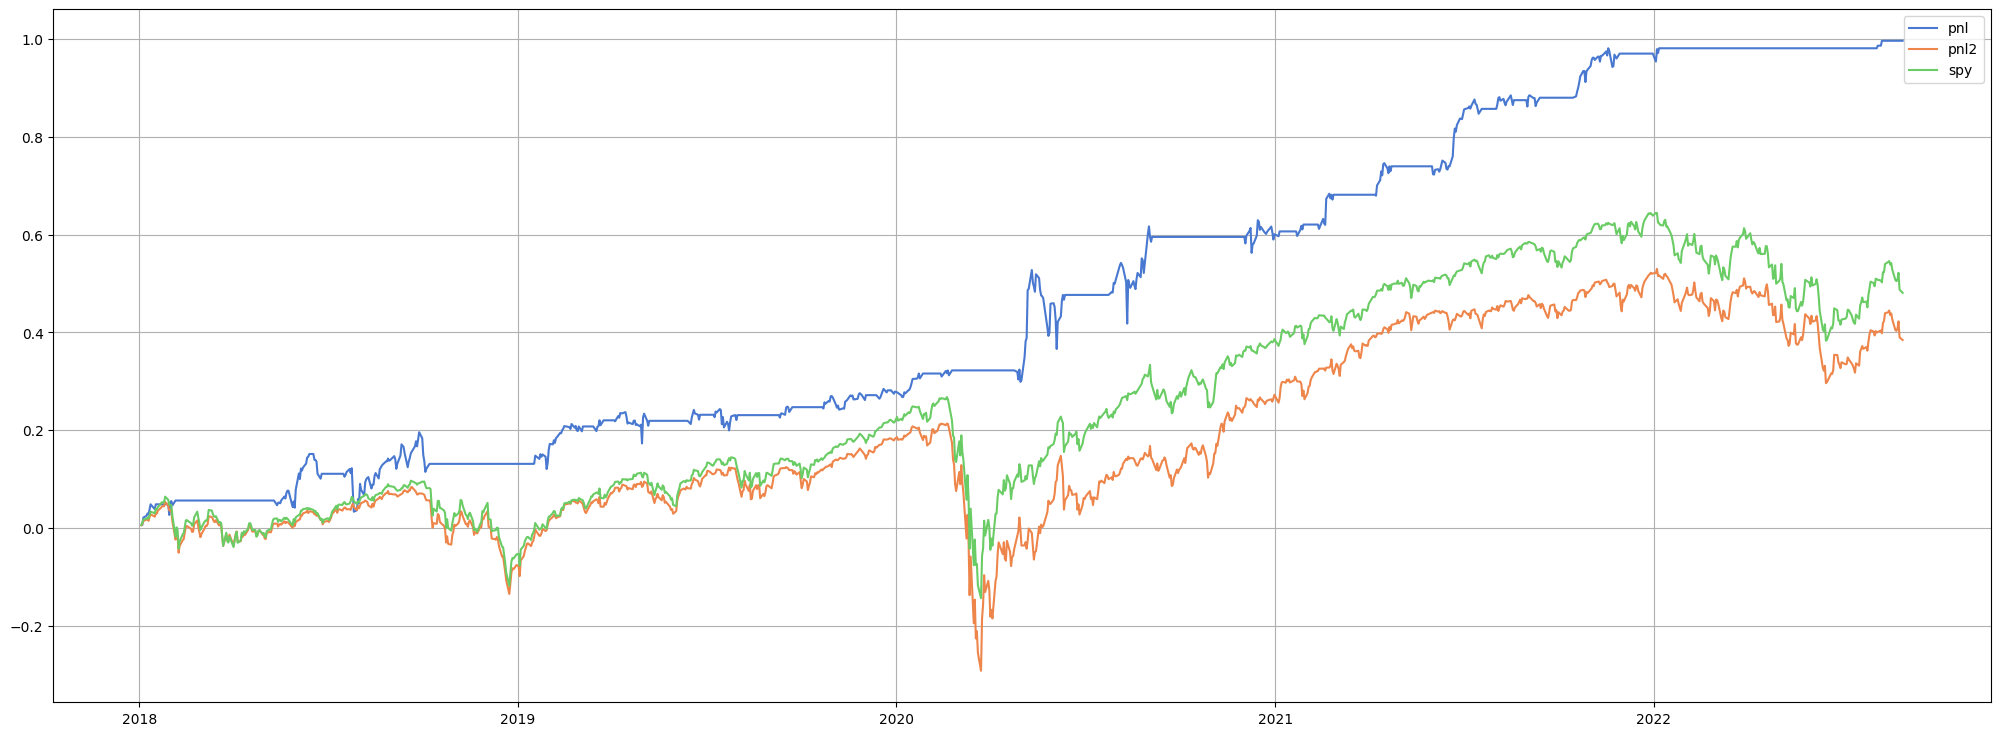

In [26]:
fig = plt.figure(figsize=(25,9))
colors = sns.color_palette("muted", 3)
plt.plot(pnl, label='pnl', color = colors[0])
plt.plot(pnl2, label = 'pnl2', color = colors[1])
plt.plot(spy, label='spy', color = colors[2])
plt.grid()
plt.legend()
plt.show()

In [ ]:
# def opt(prev_w, prev_s, curr_s, failed):
#     """
#     apply opt method, inputs are previous day's method and current method
#     and if this strategy is failed
#     """
#     if curr_s == 1 and prev_s <= 0:
#         try:
#             mu,S = al.estimate(stocks, pool, d, 360)
#             ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
#             raw_weights = ef.max_sharpe()
#             w = ef.clean_weights()
#         except:
#             failed = 1
#         prev_s += 1

#     elif curr_s == 1 and prev_s ==1:
#         w = prev_w
#         prev_s += 1

#     elif curr_s == 1 and prev_s >= 90:
#         try:
#             mu,S = al.estimate(stocks, pool, d, 360)
#             ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
#             raw_weights = ef.max_sharpe()
#             w = ef.clean_weights()
#         except:
#             failed = curr_s
#         prev_s = 1

#     elif curr_s == -1 and prev_s != -1 and prev_s != -2:
# #         print(-1)
#         try:
#             mu,S = al.estimate(stocks, pool, d, 360)
#             ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
#             raw_weights = ef.max_quadratic_utility()
#             w = ef.clean_weights()
#         except:
#             failed = curr_s
#         prev_s = -1

#     elif curr_strategy == -2:
# #         print(-2)
#         w = init_w
#         prev_strategy = -2
#     else:
#         pass
    
#     return w, prev_s, failed